# Kompresja Stratna

##k-means

W tym zadaniu chcemy dokonać kompresji zbioru danych $X$ za pomocą $k$-punktów (centroidów), tak,  że zastąpienie najbliższym centroidem ma minimnalny błąd średniokwadratowy.

Optymalizacja jest robiona naprzemiennie:
* dla danych centroidów (centrów) przyporządkowujemy im najbliższe punkty - tworzymy w ten sposób klastry
* dla każdego klastra update'ujemy jego centroid zastępując go środkiem wszystkich punktów z klastra.

Warunkiem stopu jest zazwyczaj albo liczba iteracji, albo fakt, że żaden punkt nie zmienił przynależności do innego klastra.

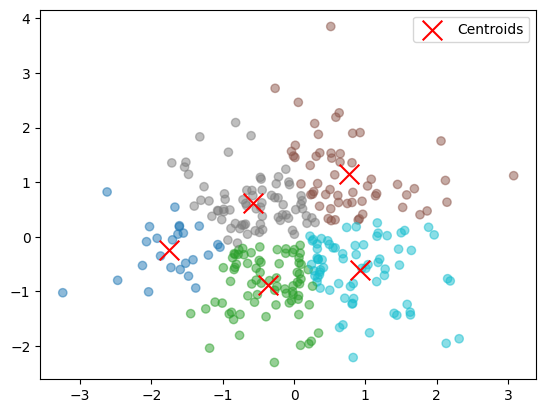

In [ ]:
import numpy as np

# Funkcja implementująca algorytm k-means
def kmeans(X, k, max_iters=100):
    # Inicjalizacja centroidów losowo z próbek danych
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Przypisanie każdego punktu do najbliższego centroidu
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Aktualizacja centroidów jako średnia punktów w klastrze
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Sprawdzenie warunku stopu (jeśli centroidy się nie zmieniają)
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

# Przykładowe dane
np.random.seed(42)
X = np.random.randn(300, 2)  # 300 punktów w 2D

# Uruchomienie k-means dla k=3
labels, centroids = kmeans(X, k=5)

# Wizualizacja wyników
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.legend()
plt.show()


## k-means
implementacja loss za pomocą sieci


Epoch 0, Loss: 0.6294
Epoch 20, Loss: 0.4886
Epoch 40, Loss: 0.4829
Epoch 60, Loss: 0.4818
Epoch 80, Loss: 0.4816
Epoch 100, Loss: 0.4816
Epoch 120, Loss: 0.4816
Epoch 140, Loss: 0.4816
Epoch 160, Loss: 0.4816
Epoch 180, Loss: 0.4816
Trening zakończony.
Finalne centroidy: [[-1.326061    1.2779714 ]
 [-0.3903949  -0.31629652]
 [-1.4343709   0.0623388 ]
 [ 0.00362753  1.4901803 ]
 [ 1.8430138   0.07445081]
 [-0.42285284  0.49540448]
 [-0.95309955 -1.2821714 ]
 [ 0.65327656 -1.7340026 ]
 [ 0.45821324 -0.59187776]
 [ 0.7216642   0.49951163]]


<ipython-input-2-6debe93cca28>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters).colors  # Dynamiczne przypisanie kolorów


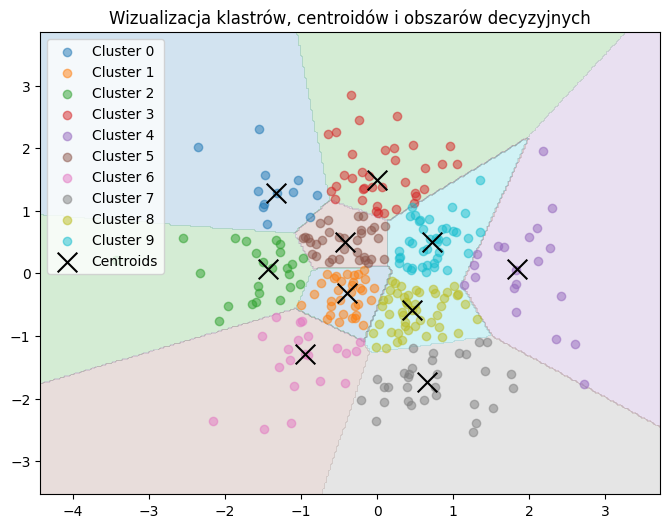

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Generowanie przykładowych danych
num_points = 300
num_clusters = 10  # Można dowolnie zmieniać liczbę klastrów
dim = 2

data = torch.randn(num_points, dim)

# Definicja prostej sieci neuronowej modelującej centroidy
class ClusterModel(nn.Module):
    def __init__(self, num_clusters, dim):
        super(ClusterModel, self).__init__()
        self.centroids = nn.Parameter(torch.randn(num_clusters, dim))

    def forward(self, x):
        # Obliczanie odległości euklidesowej od centroidów
        distances = torch.cdist(x, self.centroids)  # [num_points, num_clusters]
        assignments = torch.argmin(distances, dim=1)  # Indeksy najbliższych centroidów
        return assignments

# Funkcja straty - minimalizujemy sumę kwadratów odległości od przypisanych centroidów
def loss_function(data, centroids):
    distances = torch.cdist(data, centroids)  # [num_points, num_clusters]
    min_distances, _ = torch.min(distances, dim=1)
#    return min_distances.mean()
    return min_distances.pow(2).mean()

# Trening modelu
model = ClusterModel(num_clusters, dim)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 200

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(data, model.centroids)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("Trening zakończony.")
print("Finalne centroidy:", model.centroids.detach().numpy())

# Wizualizacja wyników
final_centroids = model.centroids.detach().numpy()
assignments = model(data).detach().numpy()
data_np = data.numpy()

plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', num_clusters).colors  # Dynamiczne przypisanie kolorów
cmap = ListedColormap(colors[:num_clusters])

# Dodanie siatki decyzyjnej
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
grid_assignments = model(grid_tensor).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, grid_assignments, alpha=0.2, cmap=cmap)

# Rysowanie punktów i centroidów
for i in range(num_clusters):
    cluster_points = data_np[assignments == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[i]], alpha=0.5, label=f'Cluster {i}')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='black', marker='x', s=200, label='Centroids')

plt.legend()
plt.title("Wizualizacja klastrów, centroidów i obszarów decyzyjnych")
plt.show()


## Rzutowanie ortogonalne

Mamy prostą/płaszczyznę/hiperpłaszczyznę $M$ zadaną wzorem:
$$
M=\{Ax+m:x \in \mathbb{R}^n\}.
$$
Chcę znaleźć odwzorowanie $p_M$ które dowolnemu punktowi $y$ z przestrzeni przyporządkowuje najbliższy w $M$. Łatwo widać, że rozwiązanie dostajemy stosując MNK: najlepsze przybliżone rozwiązanie
$$
Ax+m=y
$$
jest dane przez
$$
x_M=(A^TA)^{-1}A^T(y-m)
$$
czyli rzut to
$$
y_M=Ax_M+m
$$


ZADANIE: znajdź rzutowanie ortogonalne na płaszczyznę zadaną wzorem
$$
\{x=s,y=s+t,z=s-t+1:s,t \in \mathbb{R}\}.
$$

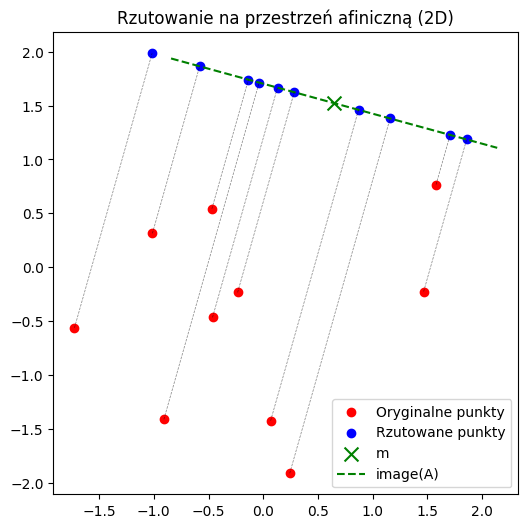

Oryginalne punkty:
 [[-0.23415337 -0.23413696]
 [ 1.57921282  0.76743473]
 [-0.46947439  0.54256004]
 [-0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024]
 [-1.72491783 -0.56228753]
 [-1.01283112  0.31424733]
 [-0.90802408 -1.4123037 ]
 [ 1.46564877 -0.2257763 ]
 [ 0.0675282  -1.42474819]]
Punkty po rzutowaniu:
 [[ 0.28320888  1.62448564]
 [ 1.70742685  1.22804334]
 [-0.13584246  1.74113189]
 [ 0.13026111  1.66705986]
 [ 1.15887775  1.38073631]
 [-1.01557821  1.98601327]
 [-0.58114326  1.86508488]
 [-0.03783438  1.71385057]
 [ 1.8586163   1.18595857]
 [ 0.87077967  1.46093068]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def project_affine(X, A, m):
    """
    Rzutowanie zbioru X na przestrzeń afiniczną m + image(A) w 2D.

    Parametry:
    X - (n, 2) macierz punktów wejściowych
    A - (2, 1) macierz bazowa przestrzeni rzutowania
    m - (2,) wektor przesunięcia przestrzeni

    Zwraca:
    X_proj - (n, 2) macierz punktów po rzutowaniu
    """

    # Rozwiązanie problemu najmniejszych kwadratów Ax = b
    A_pseudo = A @ np.linalg.pinv(A.T @ A) @ A.T  # Macierz rzutowania na image(A)

    X_proj = m + (A_pseudo @ (X - m).T).T  # Rzutowanie każdego punktu na przestrzeń afiniczną
    return X_proj

# Przykładowe dane
d = 2  # Wymiar przestrzeni
k = 1  # Wymiar przestrzeni image(A)
n = 10  # Liczba punktów

np.random.seed(42)
A = np.random.randn(d, k)  # Macierz A (jednowymiarowa przestrzeń)
m = np.random.randn(d)      # Punkt przesunięcia
X = np.random.randn(n, d)   # Punkty do rzutowania

# Rzutowanie
X_proj = project_affine(X, A, m)

# Wizualizacja dla wymiaru 2D
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], color='red', label='Oryginalne punkty')
plt.scatter(X_proj[:, 0], X_proj[:, 1], color='blue', label='Rzutowane punkty')
plt.scatter(m[0], m[1], color='green', marker='x', s=100, label='m')

# Rysowanie prostej image(A)
t = np.linspace(-3, 3, 100)
line_points = m[:, np.newaxis] + A @ t[np.newaxis, :]
plt.plot(line_points[0], line_points[1], 'g--', label='image(A)')

# Rysowanie odcinków łączących oryginalne punkty z ich rzutami
for i in range(n):
    plt.plot([X[i, 0], X_proj[i, 0]], [X[i, 1], X_proj[i, 1]], 'k--', linewidth=0.5, alpha=0.5)

plt.legend()
plt.title("Rzutowanie na przestrzeń afiniczną (2D)")
plt.show()

# Wyświetlenie wyników
print("Oryginalne punkty:\n", X)
print("Punkty po rzutowaniu:\n", X_proj)


# Jpeg

Pewne bazy są lepsze dla niektórych danych

https://en.wikipedia.org/wiki/JPEG
(baza pokazana w drugiej połowie)

bazy fouriera (współczynniki) można wyliczyć w złożoności $O(n \log n)$ w przeciwieństwie do stanadardowej zmiany bazy $O(n^2)$.



# Kompresja JPEG – skrótowe wprowadzenie

JPEG to popularny format stratnej kompresji obrazów rastrowych, szczególnie używany do zdjęć. Kompresja JPEG opiera się na przekształceniu i uproszczeniu danych obrazu w sposób możliwie mało zauważalny dla ludzkiego oka.

### Główne kroki kompresji JPEG:

1. **Konwersja do przestrzeni barw YCbCr**  
   Obraz w RGB jest przekształcany do YCbCr, gdzie:
   - Y – jasność (luminancja),
   - Cb, Cr – składowe barwne (chrominancja).  
   Ludzki wzrok jest bardziej czuły na jasność niż na kolor.

2. **Podpróbkowanie chrominancji (chroma subsampling)**  
   Składowe Cb i Cr są próbkowane z niższą rozdzielczością, np. 4:2:0.  
   Zmniejsza to dane o kolorze, ale mało wpływa na postrzeganą jakość.

3. **Podział obrazu na bloki 8×8 pikseli**  
   Obraz jest dzielony na małe bloki, które są kompresowane osobno.

4. **Dyskretna transformata kosinusowa (DCT)**  
   Każdy blok 8×8 jest przekształcany do współczynników DCT:
   
   $$
   F(u, v) = \frac{1}{4} \sum_{x=0}^{7} \sum_{y=0}^{7} f(x, y) \cdot \cos\left[\frac{(2x+1)u\pi}{16}\right] \cdot \cos\left[\frac{(2y+1)v\pi}{16}\right]
   $$

   DCT przekształca dane przestrzenne (piksele) na częstotliwości.

5. **Kwantyzacja współczynników**  
   Współczynniki DCT są dzielone przez wartości z macierzy kwantyzacji i zaokrąglane:

   $$
   F_q(u,v) = \text{round} \left( \frac{F(u,v)}{Q(u,v)} \right)
   $$

   Kwantyzacja usuwa mniej istotne (zwykle wyższe) częstotliwości.

6. **Kodowanie entropijne (np. Huffmana)**  
   Posortowane współczynniki (w tzw. kolejności zygzakowatej) są kompresowane bezstratnie za pomocą kodowania Huffmana lub arytmetycznego.

---

### Dekompresja

Dekompresja JPEG polega na odwróceniu powyższych kroków: odkodowaniu, odwrotnej kwantyzacji, odwrotnej DCT i przekształceniu z YCbCr z powrotem do RGB.

---

### Cechy JPEG:

- Efektywna kompresja przy dobrej jakości obrazu,
- Stratna – po dekompresji obraz różni się od oryginału,
- Świetnie sprawdza się dla zdjęć, ale nie dla grafik z ostrymi krawędziami (jak są ostre krawędzie występuje tak zwany ringing effect).



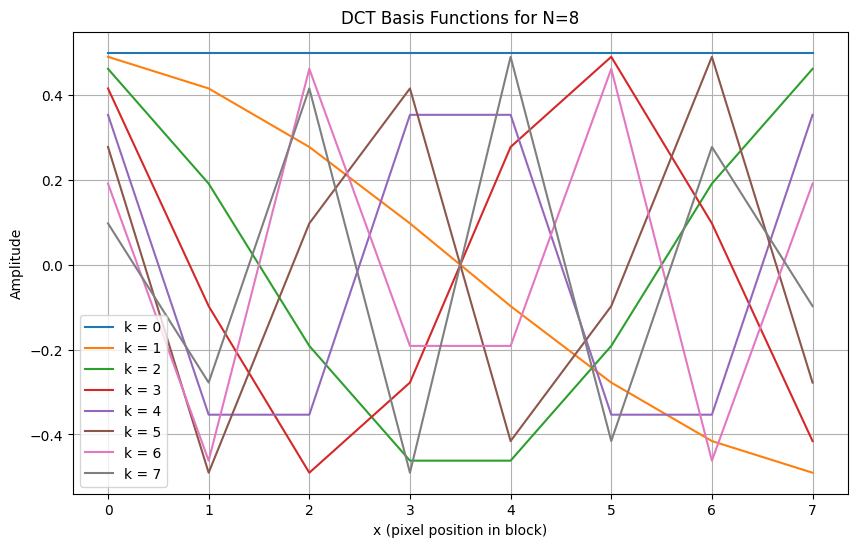

In [ ]:
"""
funkcje bazowe w jpeg
"""


import numpy as np
import matplotlib.pyplot as plt

# Parametry
N = 8  # Rozmiar bloku

# Funkcje bazowe DCT
x = np.arange(N)
basis_functions = np.zeros((N, N))

for k in range(N):
    for n in range(N):
        basis_functions[k, n] = np.sqrt(2 / N) * np.cos(np.pi * (2 * n + 1) * k / (2 * N))

# Rysowanie funkcji bazowych
plt.figure(figsize=(10, 6))

for k in range(N):
    plt.plot(x, basis_functions[k, :], label=f'k = {k}')

plt.title('DCT Basis Functions for N=8')
plt.xlabel('x (pixel position in block)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# Szukanie optymalnej bazy

Możemy się teraz spytać jaka podprzestrzeń danego wymiaru $k$ byłaby optymalna dla skompresowania zbioru danych. Czyli formalnie, szukamy takiej podprzestrzeni afinicznej $M=A \mathbb{R}^k+b$, gdzie macierz, by suma kwadratów odległości punktów z naszego zbioru $X$ od tej podprzestrzeni był minimalny. Czyli chcemy zminimalizować loss
$$
loss=\sum_i d^2(x_i;M).
$$

Dokonamy tej optymalizacji za pomocą sieci. Korzystamy z faktu, że umiemy rzutować ortogonalnie (dzięki MNK, patrz początek).

Epoch 0, Loss: 0.6725128889083862
Epoch 10, Loss: 0.27187052369117737
Epoch 20, Loss: 0.2713249921798706
Epoch 30, Loss: 0.2614344358444214
Epoch 40, Loss: 0.25747886300086975


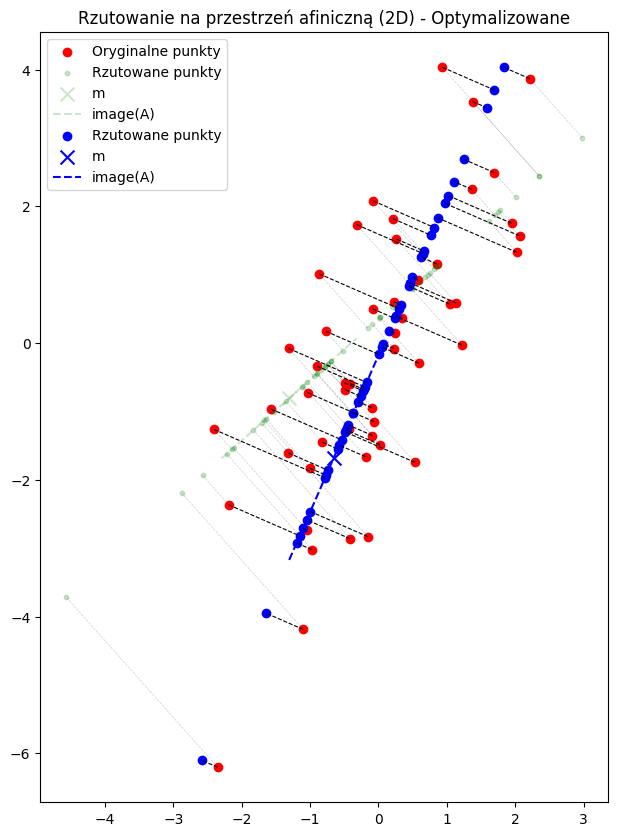

Optymalne A:
 [[0.32554924]
 [0.74620193]]
Optymalne m:
 [-0.65385276 -1.6792591 ]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def project_affine(X, A, m):
    """
    Rzutowanie zbioru X na przestrzeń afiniczną m + image(A) w 2D.

    Parametry:
    X - (n, 2) macierz punktów wejściowych
    A - (2, 1) macierz bazowa przestrzeni rzutowania
    m - (2,) wektor przesunięcia przestrzeni

    Zwraca:
    X_proj - (n, 2) macierz punktów po rzutowaniu
    """
    A_pseudo = A @ torch.linalg.pinv(A.T @ A) @ A.T  # Macierz rzutowania na image(A)
    X_proj = m + (A_pseudo @ (X - m).T).T  # Rzutowanie każdego punktu na przestrzeń afiniczną
    return X_proj

# Przykładowe dane
d = 2  # Wymiar przestrzeni
k = 1  # Wymiar przestrzeni image(A)
n = 50  # Liczba punktów

X = torch.tensor(np.random.randn(n, d)@np.random.randn(d,d), dtype=torch.float32)  # Punkty do rzutowania

# Definicja modelu optymalizującego A i m
class ProjectionModel(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        self.A = nn.Parameter(torch.randn(d, k, dtype=torch.float32))
        self.m = nn.Parameter(torch.randn(d, dtype=torch.float32))

    def forward(self, X):
        G = self.A.T @ self.A  # Macierz G=A^TA
        G_inv_sqrt = torch.linalg.inv(torch.linalg.cholesky(G))  # G^{-1/2} przez dekompozycję Cholesky'ego
        A_normalized = self.A @ G_inv_sqrt  # Aktualizacja A
        return project_affine(X, A_normalized, self.m)

# Inicjalizacja modelu
model = ProjectionModel(d, k)
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# Rzutowanie przed optymalizacją
X_proj = model(X).detach().numpy()
A_opt = model.A.detach().numpy()
m_opt = model.m.detach().numpy()

# Wizualizacja dla wymiaru 2D
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], color='red', label='Oryginalne punkty')
plt.scatter(X_proj[:, 0], X_proj[:, 1], color='green', s=10, label='Rzutowane punkty',alpha=0.2)
plt.scatter(m_opt[0], m_opt[1], color='green', marker='x', s=100, label='m',alpha=0.2)

# Rysowanie prostej image(A)
line_points = m_opt[:, np.newaxis] + A_opt @ t[np.newaxis, :]
plt.plot(line_points[0], line_points[1], 'g--', label='image(A)',alpha=0.2)

# Rysowanie odcinków łączących oryginalne punkty z ich rzutami
for i in range(n):
    plt.plot([X[i, 0], X_proj[i, 0]], [X[i, 1], X_proj[i, 1]], 'k--', linewidth=0.5,alpha=0.2)


# Trenowanie modelu
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    X_proj = model(X)
    loss = loss_fn(X_proj, X)  # Minimalizacja błędu MSE
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Rzutowanie po optymalizacji
X_proj = model(X).detach().numpy()
A_opt = model.A.detach().numpy()
m_opt = model.m.detach().numpy()

# Wizualizacja dla wymiaru 2D
plt.scatter(X_proj[:, 0], X_proj[:, 1], color='blue', label='Rzutowane punkty')
plt.scatter(m_opt[0], m_opt[1], color='blue', marker='x', s=100, label='m')

# Rysowanie prostej image(A)
t = np.linspace(-2,2, 100)
line_points = m_opt[:, np.newaxis] + A_opt @ t[np.newaxis, :]
plt.plot(line_points[0], line_points[1], 'b--', label='image(A)')

# Rysowanie odcinków łączących oryginalne punkty z ich rzutami
for i in range(n):
    plt.plot([X[i, 0], X_proj[i, 0]], [X[i, 1], X_proj[i, 1]], 'k--', linewidth=0.8)

plt.legend()
plt.title("Rzutowanie na przestrzeń afiniczną (2D) - Optymalizowane")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Wyświetlenie wyników
print("Optymalne A:\n", A_opt)
print("Optymalne m:\n", m_opt)


# PCA – Analiza Głównych Składowych (Principal Component Analysis)

Optymalne rzutowanie jest dokonywane przez PCA

**PCA (Principal Component Analysis)** to technika statystyczna służąca do redukcji wymiarowości danych przy jednoczesnym zachowaniu jak największej ilości informacji (wariancji). Polega na znalezieniu nowych osi (składowych głównych), wzdłuż których dane są najbardziej rozproszone.

### Główne cele PCA:

- Znalezienie ortonormalnych kierunków (składowych głównych), wzdłuż których dane mają największą wariancję.
- Rzutowanie danych na przestrzeń o mniejszej liczbie wymiarów bez dużej utraty informacji.

### Krok po kroku:

1. Dane są centrowane (odjęcie średniej):

$$
\mathbf{X}_{\text{centrowane}} = \mathbf{X} - \bar{\mathbf{X}}
$$

2. Oblicz macierz kowariancji:

$$
\mathbf{C} = \frac{1}{n - 1} \mathbf{X}_{\text{centrowane}}^T \mathbf{X}_{\text{centrowane}}
$$

3. Znajdź wartości własne i wektory własne macierzy $\mathbf{C}$:

$$
\mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i
$$

gdzie:
- $\lambda_i$ to wartości własne (miara wariancji w kierunku $\mathbf{v}_i$),
- $\mathbf{v}_i$ to odpowiadające wektory własne (składowe główne).

4. Wybierz $k$ głównych składowych (największe $\lambda_i$) i przekształć dane:

$$
\mathbf{Z} = \mathbf{X}_{\text{centrowane}} \cdot \mathbf{W}
$$

gdzie $\mathbf{W}$ to macierz złożona z $k$ wybranych wektorów własnych jako kolumn.

---

### Błąd rekonstrukcji

Całkowita wariancja w danych równa się sumie wszystkich wartości własnych:

$$
\text{Całkowita wariancja} = \sum_{i=1}^d \lambda_i
$$

Jeśli użyjemy tylko $k < d$ składowych głównych, to suma pominiętych wartości własnych określa **błąd rekonstrukcji** (ilość utraconej wariancji):

$$
\text{Błąd rekonstrukcji} = \sum_{i=k+1}^d \lambda_i
$$

Z kolei ilość wyjaśnionej wariancji przez pierwsze $k$ składowych wynosi:

$$
\text{Wariancja wyjaśniona} = \frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^d \lambda_i}
$$

---

### Heurystyka doboru liczby składowych

W praktyce często wybiera się najmniejsze $k$, takie że:

$$
\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^d \lambda_i} \geq 0.98
$$

czyli pierwsze $k$ składowych wyjaśniają co najmniej 98% wariancji. Popularne progi to 90%, 95% lub 98%, w zależności od tolerancji na utratę informacji.

---

### Zastosowania PCA:

- Redukcja wymiarowości (np. przed uczeniem maszynowym),
- Kompresja danych,
- Wizualizacja danych wielowymiarowych (np. rzut na 2D),
- Usuwanie szumu.

PCA jest metodą nienadzorowaną – nie korzysta z etykiet klas.


In [ ]:
data=X.numpy()
data
print("mean=",data.mean(axis=0))
Cov=np.cov(data.T,ddof=0)
eigenvalues, eigenvectors = np.linalg.eig(Cov)
print("Wartości własne:", eigenvalues)
print("Wektory własne (kolumnami):")
print(eigenvectors)

# błąd jest dokładnie taki jak znaleziony wcześcniej (MSE uśrednia po wszystkich wspólrzędnych, ponieważ są dwie,
# to aby uzyskać błąd trzeba pomnożyć przez dwa)

mean= [-0.03722215 -0.20656388]
Wartości własne: [0.51340013 4.68793647]
Wektory własne (kolumnami):
[[-0.90932631 -0.41608371]
 [ 0.41608371 -0.90932631]]


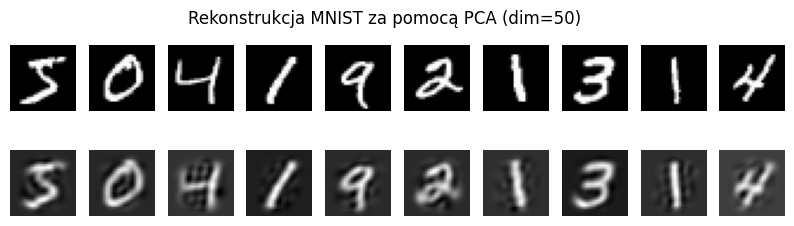

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Wczytanie zbioru MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data / 255.0  # Normalizacja pikseli do zakresu [0,1]

# Funkcja do rekonstrukcji obrazu za pomocą PCA
def reconstruct_mnist(dim):
    pca = PCA(n_components=dim)
    X_compressed = pca.fit_transform(X)  # Kompresja
    X_reconstructed = pca.inverse_transform(X_compressed)  # Rekonstrukcja

    # Wizualizacja kilku przykładowych obrazów
    fig, axes = plt.subplots(2, 10, figsize=(10, 2.5))
    for i in range(10):
        axes[0, i].imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle(f'Rekonstrukcja MNIST za pomocą PCA (dim={dim})')
    plt.show()

# Przykładowe uruchomienie
reconstruct_mnist(50)


# Nieliniowy AutoEnkoder

# Wprowadzenie do Autoenkodera

Autoenkoder to rodzaj sztucznej sieci neuronowej, który służy do uczenia się zwartej (skompresowanej) reprezentacji danych. Składa się z dwóch głównych części:

- **Koder (encoder)** – przekształca dane wejściowe w reprezentację o (zazwyczaj) niższej liczbie wymiarów (tzw. przestrzeń ukryta, ang. *latent space*),
- **Dekoder (decoder)** – rekonstruuje dane wejściowe z reprezentacji ukrytej.

Głównym celem autoenkodera jest nauczenie się funkcji odwzorowującej dane wejściowe na same siebie, przy czym sieć musi nauczyć się kompresować dane i jednocześnie minimalizować błąd rekonstrukcji.

### Schemat autoenkodera

$$
\text{[data space]} \stackrel{\text{encoder E}}{\to} \text{[latent space]} \stackrel{\text{dekoder $D$}}{\to} \text{[data space]}
$$

Chcemy by był mały błąd rekonstrukcji, czyli loss to MSE.

Zazwyczaj struktura sieci enkodera i dekodera są w przybliżeniu odwrotne (czyli warstwy układamy w odwrotnej kolejności).

#### Zastosowania autoenkoderów:
- Redukcja wymiarowości (alternatywa dla PCA),
- Usuwanie szumów z danych (*denoising autoencoders*),
- Generowanie nowych danych (np. w autoenkoderach wariacyjnych, VAE),
- Wykrywanie anomalii.

Autoenkodery są uczeniem nienadzorowanym – nie wymagają etykiet, ponieważ próbują odwzorować dane wejściowe na ich rekonstrukcję.


Epoch 0, Loss: 0.7228404879570007
Epoch 100, Loss: 0.03290412947535515
Epoch 200, Loss: 0.019035356119275093
Epoch 300, Loss: 0.015220682136714458
Epoch 400, Loss: 0.01240482833236456
Epoch 500, Loss: 0.005216411780565977
Epoch 600, Loss: 0.0050078802742064
Epoch 700, Loss: 0.005216886289417744
Epoch 800, Loss: 0.005733245052397251
Epoch 900, Loss: 0.005769567564129829
Epoch 1000, Loss: 0.004703659564256668
Epoch 1100, Loss: 0.00474667688831687
Epoch 1200, Loss: 0.007027823943644762
Epoch 1300, Loss: 0.004839682951569557
Epoch 1400, Loss: 0.004653213545680046
Epoch 1500, Loss: 0.004654057323932648
Epoch 1600, Loss: 0.004916238132864237
Epoch 1700, Loss: 0.004532149527221918
Epoch 1800, Loss: 0.004507780075073242
Epoch 1900, Loss: 0.004887458868324757


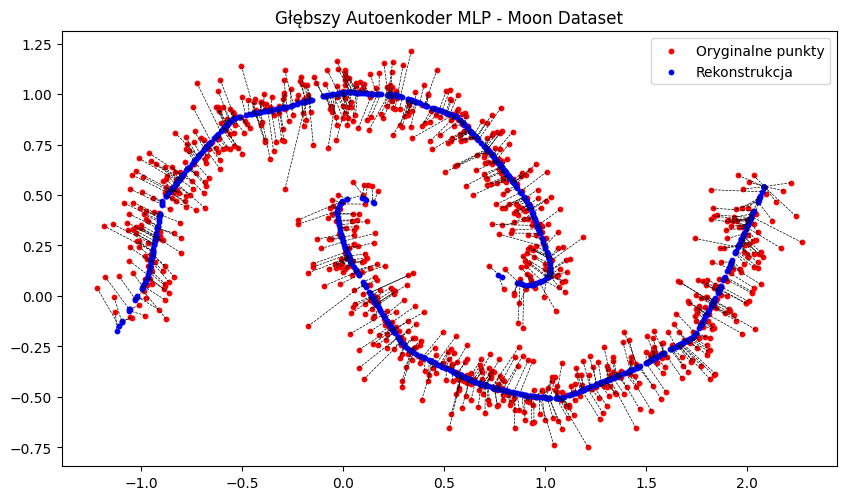

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons

# Generowanie danych
n_samples = 1000
X, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
X = torch.tensor(X, dtype=torch.float32)

# Definicja głębszego Autoenkodera
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Inicjalizacja modelu
dim_input = 2
dim_hidden = 1  # Uczenie reprezentacji na 1D przestrzeni
model = Autoencoder(dim_input, dim_hidden)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Trenowanie modelu
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    X_reconstructed = model(X)
    loss = loss_fn(X_reconstructed, X)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Rekonstrukcja danych
X_reconstructed = model(X).detach().numpy()
X = X.numpy()

# Wizualizacja
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], color='red', s=10, label='Oryginalne punkty')
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], color='blue', s=10, label='Rekonstrukcja')

# Rysowanie odcinków łączących oryginalne punkty z ich rekonstrukcją
for i in range(n_samples):
    plt.plot([X[i, 0], X_reconstructed[i, 0]], [X[i, 1], X_reconstructed[i, 1]], 'k--', linewidth=0.5)

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Głębszy Autoenkoder MLP - Moon Dataset")
plt.show()

Epoch 1, Loss: 0.03286222741007805
Epoch 2, Loss: 0.024358384311199188
Epoch 3, Loss: 0.020582839846611023
Epoch 4, Loss: 0.01655910722911358
Epoch 5, Loss: 0.018235938623547554
Epoch 6, Loss: 0.01579238846898079
Epoch 7, Loss: 0.014706030488014221
Epoch 8, Loss: 0.013952557928860188
Epoch 9, Loss: 0.011168792843818665
Epoch 10, Loss: 0.012721284292638302


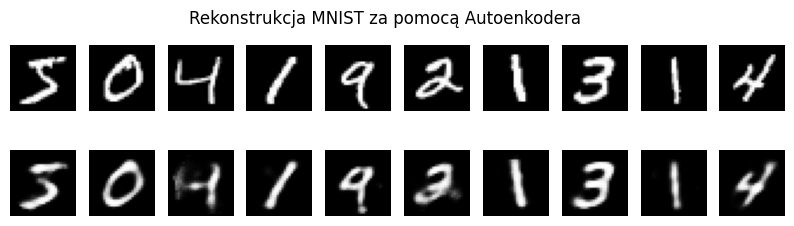

In [ ]:
"""
AutoEnkoder dla MNIST
"""


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml

# Wczytanie zbioru MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values / 255.0  # Normalizacja pikseli do zakresu [0,1]
X = torch.tensor(X, dtype=torch.float32)

# Definicja Autoenkodera bez warstw konwolucyjnych
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Parametry sieci
input_dim = 784  # 28x28 pikseli
hidden_dim = 32  # Wymiar zakodowanej reprezentacji
model = Autoencoder(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Trenowanie modelu
num_epochs = 10
batch_size = 256
X_train = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch in X_train:
        optimizer.zero_grad()
        X_reconstructed = model(batch)
        loss = loss_fn(X_reconstructed, batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Rekonstrukcja danych
X_sample = X[:10]
X_reconstructed = model(X_sample).detach().numpy()
X_sample = X_sample.numpy()

# Wizualizacja
fig, axes = plt.subplots(2, 10, figsize=(10, 2.5))
for i in range(10):
    axes[0, i].imshow(X_sample[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.suptitle(f'Rekonstrukcja MNIST za pomocą Autoenkodera')
plt.show()